In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

In [9]:
train = pd.read_csv("train.csv")
X = train.drop(labels=["label"], axis=1)
y = train["label"]

In [10]:
# Normalize the training features, to keep the result 
# in the high derivative area of activation function(sigmoid).
X = X / 255

# one hot encoding y
y = pd.get_dummies(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = X_train.values.T
X_test = X_test.values.T
y_train = y_train.values.T
y_test = y_test.values.T

6

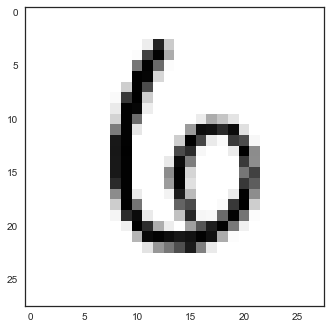

In [12]:
# plot some number
num = plt.imshow(X_train[:,1000].reshape(28,28))
np.argmax(y_train[:,1000])

In [6]:
# useful utils
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

# define L2 loss
class L2Loss():
    @staticmethod
    def loss(a, y):
        return np.sum((y - a) ** 2)
    
    @staticmethod
    def delta(z, a, y):
        return (a - y) * sigmoid_prime(z)
    
# define cross entropy loss
class CrossEntropyLoss():
    @staticmethod
    def loss(a, y):
        return np.sum(-y*np.log(a)-(1-y)*np.log(1-a))

    @staticmethod
    def delta(z, a, y):
        return a-y

In [7]:
class Ann():
    
    def __init__(self, h, s, cost=L2Loss):
        self.layers = h + 2 # plus input layer and output layer
        self.units = s # s is a list of the # of units in each hidden layer      
        self.cost = cost # use square loss
        self.training_cost = []
        self.training_accuracy = []
        self.validation_cost = []
        self.validation_accuracy = []

    def weight_initializer(self):
        # x is a column of X, Z = wX+b.T
        # implement xavier initializer
        # x: # of units in
        # y: # of units out
        self.biases = [np.random.uniform(-np.sqrt(6 / (x + y)), np.sqrt(6 / (x + y)), y) 
                       for x, y in zip(self.units[:-1], self.units[1:])]
        
        self.weights = [np.random.uniform(-np.sqrt(6 / (x + y)), np.sqrt(6 / (x + y)), [y, x])
                        for x, y in zip(self.units[:-1], self.units[1:])]

    def forward_propagation(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(w.dot(a) + b.reshape((len(b), 1)))
        return a

    def SGD(self, X, y, epochs, mini_batch_size, alpha, X_val, y_val, verbose=False):
        n = X.shape[1]       
        for epoch in range(epochs):
            mini_batches_X = [X[:,k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            mini_batches_y = [y[:,k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_X, mini_y in zip(mini_batches_X, mini_batches_y):
                self.update_mini_batch(mini_X, mini_y, alpha)
                
            train_cost = self.total_cost(X, y)
            train_accuracy = self.accuracy(X, y)
            self.training_cost.append(train_cost)
            self.training_accuracy.append(train_accuracy)
            
            val_cost = self.total_cost(X_val, y_val)
            val_accuracy = self.accuracy(X_val, y_val)
            self.validation_cost.append(val_cost)
            self.validation_accuracy.append(val_accuracy)
                      
            if verbose:   
                print(f'Complete training the {epoch}th epoch.')
                print(f'The cost on training data is {train_cost}')
                print(f'The accuracy on training data is {train_accuracy}')
                print(f'The cost on validation data is {val_cost}')
                print(f'The accuracy on validation data is {val_accuracy}\n') 

    def update_mini_batch(self, mini_X, mini_y, alpha):     
        nabla_b, nabla_w = self.back_propagation(mini_X, mini_y)       
        self.weights = [w - alpha * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - alpha * np.mean(nb, axis=1) for b, nb in zip(self.biases, nabla_b)]

    def back_propagation(self, x, y):
        """
        Calculate on batch. Return the nabla_b and nabla_w of each layer and then update
        b, w in the update_mini_batch
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # forward, cache all z's and a's
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = w.dot(activation) + b.reshape((len(b), 1))
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward, delta is the derivative of z at layer l. db = dz, dw = dz·a_{l-1}
        delta = self.cost.delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = delta.dot(activations[-2].T)
        for layer in range(2, self.layers):
            z = zs[-layer]
            sp = sigmoid_prime(z)
            delta = self.weights[-layer + 1].T.dot(delta) * sp          # dz = sum(dz·w_{postLayer}*g')
            nabla_b[-layer] = delta                                     # db = dz
            nabla_w[-layer] = delta.dot(activations[-layer-1].T)        # dw = dz·a_{preLayer}
        return nabla_b, nabla_w
    
    def fit(self, X, y, alpha, t, mini_batch_size, X_val, y_val, verbose=False):
        # X: m x n, m is # of features, n is # of examples
        m, n = X.shape
        p, q = y.shape
        self.units.insert(0, m)
        self.units.append(p)
        self.weight_initializer() # use xavier initialization
        self.SGD(X, y, t, mini_batch_size, alpha, X_val, y_val, verbose)
        
    def predict(self, T):
        return np.argmax(self.forward_propagation(T), axis=0)
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        label = np.argmax(y, axis=0)
        return sum(predictions == label) / X.shape[1]

    def total_cost(self, X, y):
        cost = 0
        a = self.forward_propagation(X)    
        for i in range(X.shape[1]):
            cost += self.cost.loss(a[:, i], y[:, i])
        return cost / X.shape[1]
    
    def print(self):
        for b, w in zip(self.biases, self.weights):
            print(b)
            print(w)

# Use L2 Loss

In [17]:
ann = Ann(3, [256, 128, 64])

In [18]:
%%time
ALPHA = 0.1
EPOCH = 20
BATCH_SIZE = 32
ann.fit(X_train, y_train, ALPHA, EPOCH, BATCH_SIZE, X_test, y_test, verbose=True)

Complete training the 0th epoch.
The cost on training data is 0.22270109828483678
The accuracy on training data is 0.8575892857142857
The cost on validation data is 0.21984813500103306
The accuracy on validation data is 0.8589285714285714

Complete training the 1th epoch.
The cost on training data is 0.11644053270408328
The accuracy on training data is 0.925625
The cost on validation data is 0.120448328045237
The accuracy on validation data is 0.9235714285714286

Complete training the 2th epoch.
The cost on training data is 0.08521824679402967
The accuracy on training data is 0.9453571428571429
The cost on validation data is 0.0943146134216432
The accuracy on validation data is 0.9398809523809524

Complete training the 3th epoch.
The cost on training data is 0.07014528695106359
The accuracy on training data is 0.9560714285714286
The cost on validation data is 0.08314750651797458
The accuracy on validation data is 0.9473809523809524

Complete training the 4th epoch.
The cost on training

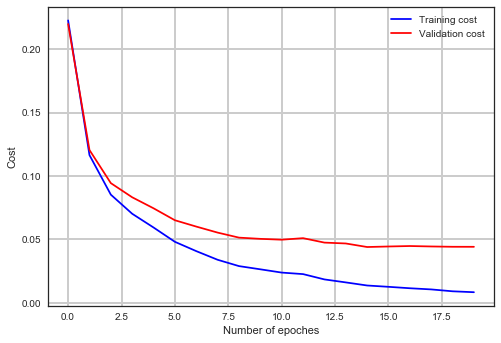

In [43]:
# plot the Training cost and Validation cost
epoches = np.arange(EPOCH)
plt.plot(epoches, ann.training_cost, color='b', label="Training cost")
plt.plot(epoches, ann.validation_cost, color='r', label="Validation cost")
plt.xlabel('Number of epoches')
plt.ylabel('Cost')
legend = plt.legend(loc='best', shadow=True)
plt.grid(linestyle='-', linewidth=2)

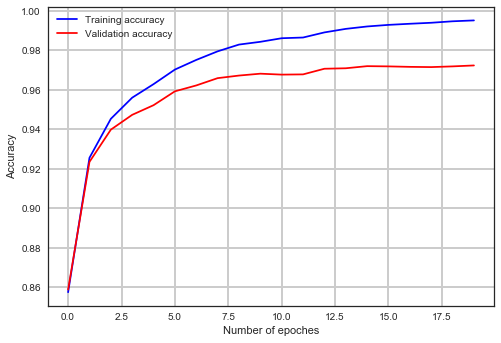

In [44]:
# plot the Training accuracy and Validation accuracy
plt.plot(epoches, ann.training_accuracy, color='b', label="Training accuracy")
plt.plot(epoches, ann.validation_accuracy ,color='r',label="Validation accuracy")
plt.xlabel('Number of epoches')
plt.ylabel('Accuracy')
legend = plt.legend(loc='best', shadow=True)
plt.grid(linestyle='-', linewidth=2)

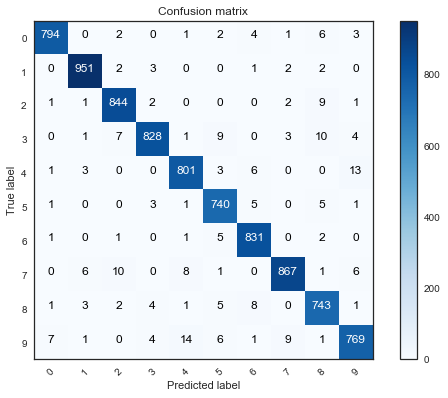

In [21]:
# plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_prediction = ann.predict(X_test)
y_true = np.argmax(y_test, axis=0)

cm = confusion_matrix(y_true, y_prediction) 
plot_confusion_matrix(cm, classes = range(10)) 

# Use Cross Entropy Loss 

In [37]:
ALPHA2 = 0.02
EPOCH2 = 20
BATCH_SIZE2 = 32

In [38]:
ann2 = Ann(3, [256, 128, 64], cost=CrossEntropyLoss)
ann2.fit(X_train, y_train, ALPHA2, EPOCH2, BATCH_SIZE2, X_test, y_test, verbose=True)

Complete training the 0th epoch.
The cost on training data is -91.07720343609994
The accuracy on training data is 0.8938690476190476
The cost on validation data is -94.01773691093527
The accuracy on validation data is 0.8964285714285715

Complete training the 1th epoch.
The cost on training data is -56.452037761746006
The accuracy on training data is 0.934375
The cost on validation data is -61.97056422191535
The accuracy on validation data is 0.9305952380952381

Complete training the 2th epoch.
The cost on training data is -39.685778249135666
The accuracy on training data is 0.9559821428571429
The cost on validation data is -48.25508778756574
The accuracy on validation data is 0.9480952380952381

Complete training the 3th epoch.
The cost on training data is -28.52020274763544
The accuracy on training data is 0.9693452380952381
The cost on validation data is -39.30875618790141
The accuracy on validation data is 0.9564285714285714

Complete training the 4th epoch.
The cost on training da

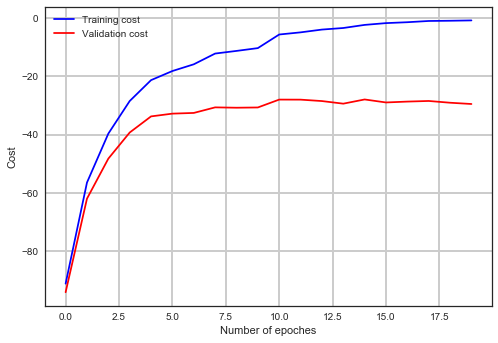

In [45]:
plt.plot(epoches, ann2.training_cost, color='b', label="Training cost")
plt.plot(epoches, ann2.validation_cost, color='r', label="Validation cost")
plt.xlabel('Number of epoches')
plt.ylabel('Cost')
legend = plt.legend(loc='best', shadow=True)
plt.grid(linestyle='-', linewidth=2)

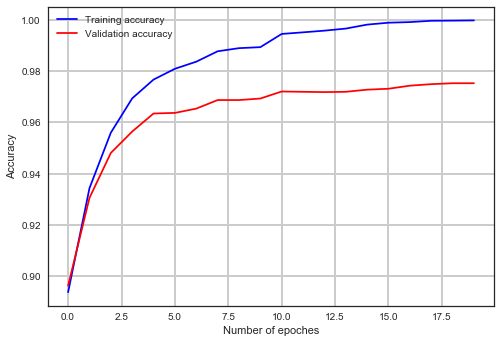

In [46]:
plt.plot(epoches, ann2.training_accuracy, color='b', label="Training accuracy")
plt.plot(epoches, ann2.validation_accuracy ,color='r',label="Validation accuracy")
plt.xlabel('Number of epoches')
plt.ylabel('Accuracy')
legend = plt.legend(loc='best', shadow=True)
plt.grid(linestyle='-', linewidth=2)

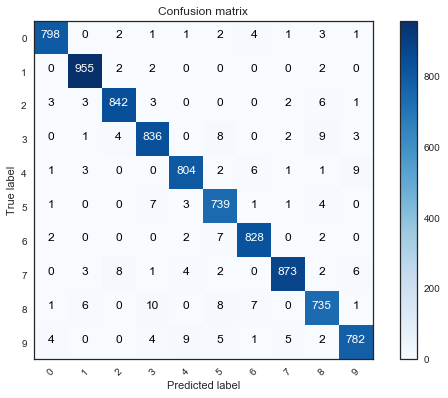

In [41]:
y_prediction2 = ann2.predict(X_test)
y_true = np.argmax(y_test, axis=0)

cm2 = confusion_matrix(y_true, y_prediction2) 
plot_confusion_matrix(cm2, classes = range(10)) 